# Regression test suite: Test of basic SSP GCE features

Prepared by Christian Ritter

Test of SSP with artificial yields,pure h1 yields, provided in NuGrid tables (no PopIII tests here). Focus are basic GCE features.
You can find the documentation <a href="doc/sygma.html">here</a>.

Before starting the test make sure that use the standard yield input files.





## Outline:

$\odot$ Evolution of ISM fine

$\odot$ Sources of massive and AGB stars distinguished

$\odot$ Test of final mass of ISM for different IMF boundaries

$\odot$ Test of Salpeter, Chabrier, Kroupa IMF by checking  the evolution of ISM mass (incl. alphaimf)

$\odot$ Test if SNIa on/off works

$\odot$ Test of the three SNIa implementations, the evolution of SN1a contributions

$\odot$ Test of parameter tend, dt and special_timesteps

$\odot$ Test of parmeter mgal

$\odot$ Test of parameter transitionmass

TODO: test non-linear yield fitting (hard set in code right now, no input parameter provided)


In [1]:
#from imp import *
#s=load_source('sygma','/home/nugrid/nugrid/SYGMA/SYGMA_online/SYGMA_dev/sygma.py')
#%pylab nbagg
import sys
import sygma as s
print (s.__file__)
s.__file__
#import matplotlib
#matplotlib.use('nbagg')
import matplotlib.pyplot as plt
#matplotlib.use('nbagg')
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import os

# Trigger interactive or non-interactive depending on command line argument
__RUNIPY__ = sys.argv[0]

if __RUNIPY__:
    %matplotlib inline
else:
    %pylab nbagg

/Users/benoitcote/Desktop/OMEGA_SYGMA_inheritance/sygma.py


### IMF notes:

The IMF allows to calculate the number of stars $N_{12}$ in the mass interval [m1,m2] with

(I) $N_{12}$ = k_N $\int _{m1}^{m2} m^{-2.35} dm$ 

Where k_N is the normalization constant. It can be derived from the total amount of mass of the system $M_{tot}$
since the total mass $M_{12}$ in the mass interval above can be estimated with

(II) $M_{12}$ = k_N $\int _{m1}^{m2} m^{-1.35} dm$

With a total mass interval of [1,30] and $M_{tot}=1e11$ the $k_N$ can be derived:

$1e11 = k_N/0.35 * (1^{-0.35} - 30^{-0.35})$

In [2]:
k_N=1e11*0.35/ (1**-0.35 - 30**-0.35) #(I)

The total number of stars $N_{tot}$ is then:

In [4]:
N_tot=k_N/1.35 * (1**-1.35 - 30**-1.35) #(II)
print (N_tot)

36877281297.19034


With a yield ejected of $0.1 Msun$, the total amount ejected is:

In [5]:
Yield_tot=0.1*N_tot
print (Yield_tot/1e11)

0.03687728129719034


compared to the simulation:

In [6]:
s1=s.sygma(iolevel=0,mgal=1e11,dt=1e7,imf_type='salpeter',imf_bdys=[1,30],iniZ=0.02,hardsetZ=0.0001,
           table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', 
           iniabu_table='yield_tables/iniabu/iniab_h1.ppn',pop3_table='yield_tables/popIII_h1.txt')
Yield_tot_sim=s1.history.ism_iso_yield[-1][0]
#% matplotlib inline

SYGMA run in progress..
   SYGMA run completed - Run time: 0.28s


In [7]:
import read_yields as ry
path = os.environ['SYGMADIR']+'/yield_tables/agb_and_massive_stars_nugrid_MESAonly_fryer12delay.txt'
#path='/home/christian/NuGrid/SYGMA_PROJECT/NUPYCEE/new/nupycee.bitbucket.org/yield_tables/isotope_yield_table.txt'
ytables = ry.read_nugrid_yields(path,excludemass=[32,60])
zm_lifetime_grid=s1.zm_lifetime_grid_current #__interpolate_lifetimes_grid()
#return           [[metallicities Z1,Z2,...], [masses], [[log10(lifetimesofZ1)],
#           [log10(lifetimesofZ2)],..] ]
#s1.__find_lifetimes()

#minm1 = self.__find_lifetimes(round(self.zmetal,6),mass=[minm,maxm], lifetime=lifetimemax1)

Compare both results:

In [8]:
print (Yield_tot_sim)
print (Yield_tot)
print ('ratio should be 1 : ',Yield_tot_sim/Yield_tot)

3687728129.72
3687728129.719034
ratio should be 1 :  1.0


### Test of distinguishing between massive and AGB sources:

Boundaries between AGB and massive for Z=0 (1e-4) at 8 (transitionmass parameter)

In [9]:
Yield_agb= ( k_N/1.35 * (1**-1.35 - 8.**-1.35) ) * 0.1
Yield_massive= ( k_N/1.35 * (8.**-1.35 - 30**-1.35) ) * 0.1

In [10]:
print ('Should be 1:',Yield_agb/s1.history.ism_iso_yield_agb[-1][0])
print ('Should be 1:',Yield_massive/s1.history.ism_iso_yield_massive[-1][0])
print ('Test total number of SNII agree with massive star yields: ',sum(s1.history.sn2_numbers)*0.1/Yield_massive)
print ( sum(s1.history.sn2_numbers))

Should be 1: 1.0
Should be 1: 1.0
Test total number of SNII agree with massive star yields:  1.0
1871484249.69


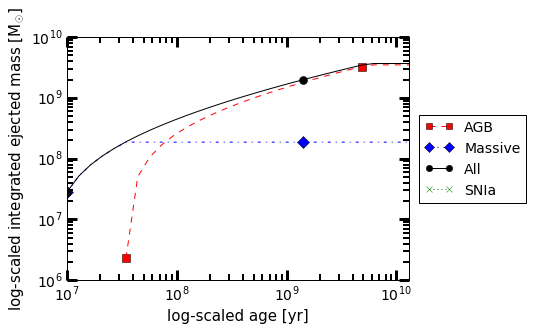

In [11]:
s1.plot_totmasses(source='agb')
s1.plot_totmasses(source='massive')
s1.plot_totmasses(source='all')
s1.plot_totmasses(source='sn1a')

### Calculating yield ejection over time 

For plotting, take the lifetimes/masses from the yield grid:

$
Ini Mass & Age [yrs]
1Msun = 5.67e9
1.65 = 1.211e9
2 = 6.972e8
3 = 2.471e8
4 = 1.347e8
5 = 8.123e7
6 = 5.642e7
7 = 4.217e7
12 = 1.892e7
15 = 1.381e7
20 = 9.895e6
25 = 7.902e6
$

In [12]:
s1=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,imf_type='salpeter',alphaimf=2.35,\
           imf_bdys=[1,30],iniZ=0,hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, \
           sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
Yield_tot_sim=s1.history.ism_iso_yield[-1][0]

SYGMA run in progress..
   SYGMA run completed - Run time: 0.28s


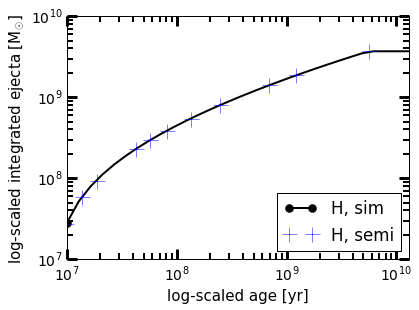

In [13]:
s1.plot_mass(specie='H',label='H, sim',color='k',shape='-',marker='o',markevery=800)
m=[1,1.65,2,3,4,5,6,7,12,15,20,25]
ages=[5.67e9,1.211e9,6.972e8,2.471e8,1.347e8,8.123e7,5.642e7,4.217e7,1.892e7,1.381e7,9.895e6,7.902e6]
def yields(m,k_N):
    return ( k_N/1.35 * (m**-1.35 - 30.**-1.35) ) * 0.1
yields1=[]
for m1 in m:
    yields1.append(yields(m1,k_N))
plt.plot(ages,yields1,marker='+',linestyle='',markersize=15,label='H, semi')
plt.legend(loc=4)

Simulation results in the plot above should agree with semi-analytical calculations.

### Test of parameter imf_bdys: Selection of different initial mass intervals

##### Select imf_bdys=[5,20]

In [14]:
k_N=1e11*0.35/ (5**-0.35 - 20**-0.35)
N_tot=k_N/1.35 * (5**-1.35 - 20**-1.35)
Yield_tot=0.1*N_tot

In [15]:
s1=s.sygma(iolevel=0,mgal=1e11,dt=1e9,tend=1.3e10,imf_type='salpeter',\
           imf_bdys=[5,20],hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, \
           sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
Yield_tot_sim=s1.history.ism_iso_yield[-1][0]

SYGMA run in progress..
   SYGMA run completed - Run time: 0.26s


In [16]:
print ('Sould be 1:' ,Yield_tot_sim/Yield_tot)

Sould be 1: 1.0


##### Select imf_bdys=[1,5]

In [17]:
k_N=1e11*0.35/ (1**-0.35 - 5**-0.35)
N_tot=k_N/1.35 * (1**-1.35 - 5**-1.35)
Yield_tot=0.1*N_tot

In [18]:
s1=s.sygma(iolevel=0,mgal=1e11,dt=1e9,tend=1.3e10,imf_type='salpeter',alphaimf=2.35,\
           imf_bdys=[1,5],hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',\
           sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
Yield_tot_sim=s1.history.ism_iso_yield[-1][0]

SYGMA run in progress..
   SYGMA run completed - Run time: 0.26s


Results:

In [19]:
print ('Sould be 1: ',Yield_tot_sim/Yield_tot)

Sould be 1:  1.0


### Test of parameter imf_type: Selection of different IMF types

#### power-law exponent : alpha_imf

The IMF allows to calculate the number of stars $N_{12}$ in the mass interval [m1,m2] with

$N_{12}$ = k_N $\int _{m1}^{m2} m^{-alphaimf} dm$

Where k_N is the normalization constant. It can be derived from the total amount of mass of the system $M_{tot}$
since the total mass $M_{12}$ in the mass interval above can be estimated with

$M_{12}$ = k_N $\int _{m1}^{m2} m^{-(alphaimf-1)} dm$

With a total mass interval of [1,30] and $M_{tot}=1e11$ the $k_N$ can be derived:

$1e11 = k_N/(alphaimf-2) * (1^{-(alphaimf-2)} - 30^{-(alphaimf-2)})$

In [20]:
alphaimf = 1.5 #Set test alphaimf

In [21]:
k_N=1e11*(alphaimf-2)/ (-1**-(alphaimf-2) + 30**-(alphaimf-2))
N_tot=k_N/(alphaimf-1) * (-1**-(alphaimf-1) + 30**-(alphaimf-1))
Yield_tot=0.1*N_tot

In [22]:
s1=s.sygma(iolevel=0,mgal=1e11,dt=1e9,tend=1.3e10,imf_type='alphaimf',alphaimf=1.5,imf_bdys=[1,30],hardsetZ=0.0001,
           table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', 
           iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
Yield_tot_sim=s1.history.ism_iso_yield[-1][0]

SYGMA run in progress..
   SYGMA run completed - Run time: 0.27s


In [23]:
print ('Should be 1 :',Yield_tot/Yield_tot_sim)

Should be 1 : 1.0


#### Chabrier:

Change interval now from [0.01,30]

M<1: $IMF(m) = \frac{0.158}{m} * \exp{ \frac{-(log(m) - log(0.08))^2}{2*0.69^2}}$

else: $IMF(m) = m^{-2.3}$

In [24]:
def imf_times_m(mass):
    if mass<=1:
        return 0.158 * np.exp( -np.log10(mass/0.079)**2 / (2.*0.69**2))
    else:
        return mass*0.0443*mass**(-2.3)
k_N= 1e11/ (quad(imf_times_m,0.01,30)[0] )

In [25]:
N_tot=k_N/1.3 * 0.0443* (1**-1.3 - 30**-1.3)
Yield_tot=N_tot * 0.1

In [26]:
s1=s.sygma(iolevel=0,mgal=1e11,dt=1e9,tend=1.3e10,imf_type='chabrier',imf_bdys=[0.01,30],
           hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, 
           sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
Yield_tot_sim=s1.history.ism_iso_yield[-1][0]

SYGMA run in progress..
   SYGMA run completed - Run time: 0.28s


In [27]:
print (Yield_tot)
print (Yield_tot_sim)
print ('Should be 1 :',Yield_tot/Yield_tot_sim)

1844499958.2230008
1844499958.22
Should be 1 : 1.0


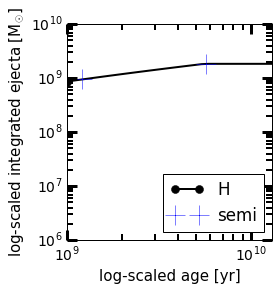

In [28]:
plt.figure(11)
s1.plot_mass(fig=11,specie='H',label='H',color='k',shape='-',marker='o',markevery=800)
m=[1,1.65,2,3,4,5,6,7,12,15,20,25]
ages=[5.67e9,1.211e9,6.972e8,2.471e8,1.347e8,8.123e7,5.642e7,4.217e7,1.892e7,1.381e7,9.895e6,7.902e6]
def yields(m,k_N):
    return ( k_N/1.3 * 0.0443*(m**-1.3 - 30.**-1.3) ) * 0.1
yields1=[]
for m1 in m:
    yields1.append(yields(m1,k_N))
plt.plot(ages,yields1,marker='+',linestyle='',markersize=20,label='semi')
plt.legend(loc=4)

Simulation should agree with semi-analytical calculations for Chabrier IMF.

#### Kroupa:

M<0.08: $IMF(m) = m^{-0.3}$

M<0.5 : $IMF(m) = m^{-1.3}$

else : $IMF(m) = m^{-2.3}$

In [29]:
def imf_times_m(mass):
    p0=1.
    p1=0.08**(-0.3+1.3)
    p2=0.5**(-1.3+2.3)
    p3= 1**(-2.3+2.3)
    if mass<0.08:
         return mass*p0*mass**(-0.3)
    elif mass < 0.5:
         return mass*p1*mass**(-1.3)
    else: #mass>=0.5:
         return mass*p1*p2*mass**(-2.3)
k_N= 1e11/ (quad(imf_times_m,0.01,30)[0] )

In [30]:
p1=0.08**(-0.3+1.3)
p2=0.5**(-1.3+2.3)
N_tot=k_N/1.3 * p1*p2*(1**-1.3 - 30**-1.3)
Yield_tot=N_tot * 0.1

In [31]:
s1=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,imf_type='kroupa',imf_bdys=[0.01,30],
           hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, 
           sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
Yield_tot_sim=s1.history.ism_iso_yield[-1][0]

SYGMA run in progress..
   SYGMA run completed - Run time: 0.29s


In [32]:
print ('Should be 1: ',Yield_tot/Yield_tot_sim)

Should be 1:  1.0


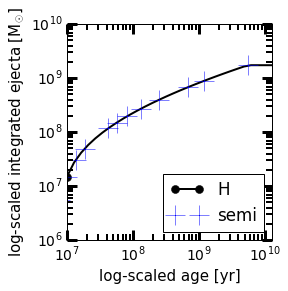

In [33]:
plt.figure(111)
s1.plot_mass(fig=111,specie='H',label='H',color='k',shape='-',marker='o',markevery=800)
m=[1,1.65,2,3,4,5,6,7,12,15,20,25]
ages=[5.67e9,1.211e9,6.972e8,2.471e8,1.347e8,8.123e7,5.642e7,4.217e7,1.892e7,1.381e7,9.895e6,7.902e6]
def yields(m,k_N):
    return ( k_N/1.3 *p1*p2* (m**-1.3 - 30.**-1.3) ) * 0.1
yields1=[]
for m1 in m:
    yields1.append(yields(m1,k_N))
plt.plot(ages,yields1,marker='+',linestyle='',markersize=20,label='semi')
plt.legend(loc=4)

Simulation results compared with semi-analytical calculations for Kroupa IMF.

### Test of parameter sn1a_on: on/off mechanism

In [34]:
s1=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,sn1a_on=False,sn1a_rate='maoz',imf_type='salpeter',
           imf_bdys=[1,30],hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',
           sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
s2=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,sn1a_on=True,sn1a_rate='maoz',imf_type='salpeter',
           imf_bdys=[1,30],hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',
           sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')

SYGMA run in progress..
   SYGMA run completed - Run time: 0.28s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.28s


[0.0] [0.0]
[100000000000.0] [3687728129.7190337]
[0.0] [9999999.9999999981]
[100000000000.0] [3697728129.7190342]
1.0


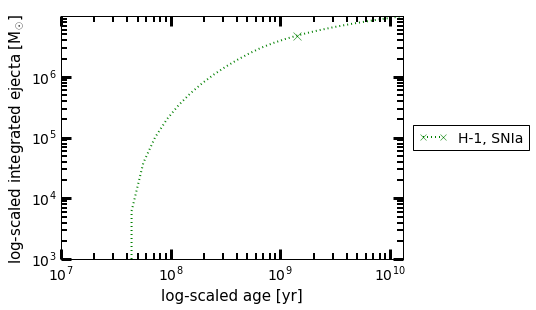

In [35]:
print ((s1.history.ism_elem_yield_1a[0]),(s1.history.ism_elem_yield_1a[-1]))
print ((s1.history.ism_elem_yield[0]),(s1.history.ism_elem_yield[-1]))
print ((s2.history.ism_elem_yield_1a[0]),(s2.history.ism_elem_yield_1a[-1]))
print ((s2.history.ism_elem_yield[0]),(s2.history.ism_elem_yield[-1]))
print ((s1.history.ism_elem_yield[-1][0] + s2.history.ism_elem_yield_1a[-1][0])/s2.history.ism_elem_yield[-1][0])
s2.plot_mass(fig=33,specie='H-1',source='sn1a') #plot s1 data  (without sn) cannot be plotted -> error, maybe change plot function?

############################################################################################

### Test of parameter sn1a_rate (DTD): Different SN1a rate implementatinos

Calculate with SNIa and look at SNIa contribution only. Calculated for each implementation from $4*10^7$ until $1.5*10^{10}$ yrs 

##### DTD taken from Vogelsberger 2013 (sn1a_rate='vogelsberger')

$\frac{N_{1a}}{Msun} = \int _t^{t+\Delta t} 1.3*10^{-3} * (\frac{t}{4*10^7})^{-1.12} * \frac{1.12 -1}{4*10^7}$   for  $t>4*10^7 yrs$

def dtd(t):
    return 1.3e-3*(t/4e7)**-1.12 * ((1.12-1)/4e7)
n1a_msun= quad(dtd,4e7,1.5e10)[0]
Yield_tot=n1a_msun*1e11*0.1 * 7 #special factor
print Yield_tot

reload(s)
s1=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,sn1a_on=True,sn1a_rate='vogelsberger',imf_type='salpeter',imf_bdys=[1,30],iniZ=-1,hardsetZ=0.0001,table='yield_tables/isotope_yield_table_h1.txt', sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab1.0E-04GN93_alpha_h1.ppn')
Yield_tot_sim=s1.history.ism_iso_yield_1a[-1][0]


print 'Should be 1: ',Yield_tot/Yield_tot_sim

s1.plot_mass(specie='H',source='sn1a',label='H',color='k',shape='-',marker='o',markevery=800)
m=[1,1.65,2,3,4,5,6,7,12,15,20,25]
ages=[5.67e9,1.211e9,6.972e8,2.471e8,1.347e8,8.123e7,5.642e7,4.217e7,1.892e7,1.381e7,9.895e6,7.902e6]
def yields(t):
    def dtd(t):
        return 1.3e-3*(t/4e7)**-1.12 * ((1.12-1)/4e7)
    return quad(dtd,4e7,t)[0]*1e11*0.1 * 7 #special factor
yields1=[]
ages1=[]
for m1 in m:
    t=ages[m.index(m1)]
    if t>4e7:
        yields1.append(yields(t))
        ages1.append(t)
plt.plot(ages1,yields1,marker='+',linestyle='',markersize=20,label='semi')
plt.legend(loc=4)

Simulation results should agree with semi-analytical calculations for the SN1 yields.

### Exponential DTD taken from Wiersma09 (sn1a_rate='wiersmaexp') (maybe transitionmass should replace 8Msun?)

$\frac{N_{1a}}{Msun} = \int _t ^{t+\Delta t} f_{wd}(t) exp(-t/\tau)/\tau$ with 

if $M_z(t) >3$ : 

$f_{wd}(t) = (\int _{M(t)}^8 IMF(m) dm)$

else:    

$f_{wd}(t) = 0$

with $M(t) = max(3, M_z(t))$ and  $M_z(t)$ being the mass-lifetime function.

NOTE: This mass-lifetime function needs to be extracted from the simulation (calculated in SYGMA, see below)


The following performs the simulation but also takes the mass-metallicity-lifetime grid from this simulation.
With the mass-lifetime spline function calculated the integration can be done further down. See also the fit for this function below.

SYGMA run in progress..
   SYGMA run completed - Run time: 0.84s


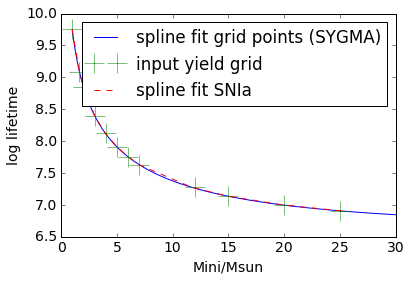

In [36]:
plt.figure(99)
#interpolate_lifetimes_grid=s22.__interpolate_lifetimes_grid
#ytables=ry.read_nugrid_yields('yield_tables/isotope_yield_table_h1.txt')
#zm_lifetime_grid=interpolate_lifetimes_grid(ytables,iolevel=0) 1e7
s1=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,sn1a_on=True,sn1a_rate='exp',
           imf_type='salpeter',imf_bdys=[1,30],hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt', 
           sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
Yield_tot_sim=s1.history.ism_iso_yield_1a[-1][0]
zm_lifetime_grid=s1.zm_lifetime_grid_current
idx_z = (np.abs(zm_lifetime_grid[0]-0.0001)).argmin() #Z=0
grid_masses=zm_lifetime_grid[1][::-1]
grid_lifetimes=zm_lifetime_grid[2][idx_z][::-1]
spline_degree1=2
smoothing1=0
boundary=[None,None]
spline_lifetime = UnivariateSpline(grid_lifetimes,np.log10(grid_masses),bbox=boundary,k=spline_degree1,s=smoothing1)
plt.plot(grid_masses,grid_lifetimes,label='spline fit grid points (SYGMA)')
plt.xlabel('Mini/Msun')
plt.ylabel('log lifetime')
m=[1,1.65,2,3,4,5,6,7,12,15,20,25]
ages=[5.67e9,1.211e9,6.972e8,2.471e8,1.347e8,8.123e7,5.642e7,4.217e7,1.892e7,1.381e7,9.895e6,7.902e6]
plt.plot(np.array(m),np.log10(np.array(ages)),marker='+',markersize=20,label='input yield grid',linestyle='None')
plt.plot(10**spline_lifetime(np.log10(ages)),np.log10(ages),linestyle='--',label='spline fit SNIa')
plt.legend()
#plt.yscale('log')

Small test: Initial mass vs. lifetime from the input yield grid compared to the fit in the the Mass-Metallicity-lifetime plane (done by SYGMA) for Z=0.02.

A double integration has to be performed in order to solve the complex integral from Wiersma:

In [37]:
#following inside function wiersma09_efolding

#if timemin ==0:
#    timemin=1

from scipy.integrate import dblquad
def spline1(x):
    #x=t
    minm_prog1a=3
    #if minimum progenitor mass is larger than 3Msun due to IMF range:
    #if self.imf_bdys[0]>3:
    #    minm_prog1a=self.imf_bdys[0]
    return max(minm_prog1a,10**spline_lifetime(np.log10(x)))


def f_wd_dtd(m,t):
                #print ('time ',t)
                #print ('mass ',m)
                mlim=10**spline_lifetime(np.log10(t))
                maxm_prog1a=8
                #if maximum progenitor mass is smaller than 8Msun due to IMF range:
                #if 8>self.imf_bdys[1]:
                #        maxm_prog1a=self.imf_bdys[1]
                if mlim>maxm_prog1a:
                        return 0
                else:
                        #Delay time distribution function (DTD)
                        tau=  2e9
                        mmin=0
                        mmax=0
                        inte=0
                #follwing is done in __imf()
                def g2(mm):
                    return mm*mm**-2.35
                norm=1./quad(g2,1,30)[0]
                #print ('IMF test',norm*m**-2.35)
                #imf normalized to 1Msun
                return  norm*m**-2.35* np.exp(-t/tau)/tau
                
a= 0.01 #normalization parameter
#if spline(np.log10(t))
#a=1e-3/()
a=1e-3/(dblquad(f_wd_dtd,0,1.3e10,lambda x: spline1(x), lambda x: 8)[0]   )
n1a= a* dblquad(f_wd_dtd,0,1.3e10,lambda x: spline1(x), lambda x: 8)[0]   
# in principle since normalization is set: nb_1a_per_m the above calculation is not necessary anymore
Yield_tot=n1a*1e11*0.1 *1 #7 #special factor

In [38]:
print (Yield_tot_sim)
print (Yield_tot)
print ('Should be : ', Yield_tot_sim/Yield_tot)

10000001.8389
10000000.0
Should be :  1.00000018389


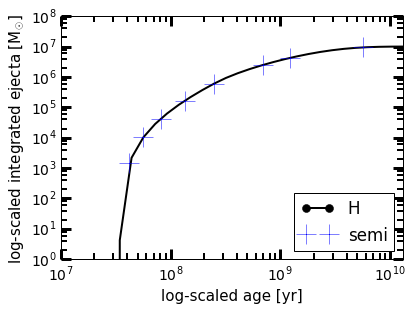

In [39]:
s1.plot_mass(specie='H',source='sn1a',label='H',color='k',shape='-',marker='o',markevery=800)
yields1=[]
ages1=[]
a= 0.01 #normalization parameter
a=1e-3/(dblquad(f_wd_dtd,0,1.3e10,lambda x: spline1(x), lambda x: 8)[0]   )
for m1 in m:
    t=ages[m.index(m1)]
    yields= a* dblquad(f_wd_dtd,0,t,lambda x: spline1(x), lambda x: 8)[0] *1e11*0.1 #special factor 
    yields1.append(yields)
    ages1.append(t)
plt.plot(ages1,yields1,marker='+',linestyle='',markersize=20,label='semi')
plt.legend(loc=4)

Simulation results compared with semi-analytical calculations for the SN1 sources with Wiersma (exp) implementation.

#### Compare number of WD's in range

In [40]:
print (sum(s1.wd_sn1a_range1)/sum(s1.wd_sn1a_range))

1.0


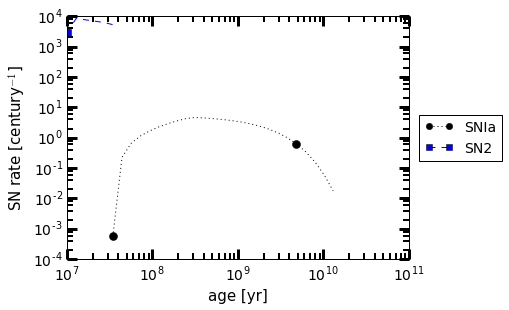

In [41]:
s1.plot_sn_distr(xaxis='time',fraction=False)

## Wiersmagauss

In [42]:
s2=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,sn1a_rate='gauss',imf_type='salpeter',
           imf_bdys=[1,30],hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=True, 
           sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
Yield_tot_sim=s2.history.ism_iso_yield_1a[-1][0]
zm_lifetime_grid=s2.zm_lifetime_grid_current
idx_z = (np.abs(zm_lifetime_grid[0]-0.0001)).argmin() #Z=0
grid_masses=zm_lifetime_grid[1][::-1]
grid_lifetimes=zm_lifetime_grid[2][idx_z][::-1]
spline_degree1=2
smoothing1=0
boundary=[None,None]
spline = UnivariateSpline(grid_lifetimes,np.log10(grid_masses),bbox=boundary,k=spline_degree1,s=smoothing1)

SYGMA run in progress..
   SYGMA run completed - Run time: 0.89s


In [43]:
from scipy.integrate import dblquad
def spline1(x):
    #x=t
    return max(3.,10**spline(np.log10(x)))
def f_wd_dtd(m,t):
        #print ('time ',t)
        #print ('mass ',m)
        mlim=10**spline(np.log10(t))
        #print ('mlim',mlim)
        if mlim>8.:
                return 0
        else:
                #mmin=max(3.,massfunc(t))
                #mmax=8.
                #imf=self.__imf(mmin,mmax,1)
                #Delay time distribution function (DTD)
                tau=  1e9 #3.3e9 #characteristic delay time
                sigma=0.66e9#0.25*tau 
                #sigma=0.2#narrow distribution
                #sigma=0.5*tau #wide distribution
                mmin=0
                mmax=0
                inte=0
                def g2(mm):
                    return mm*mm**-2.35
                norm=1./quad(g2,1,30)[0]
                #imf normalized to 1Msun
                return  norm*m**-2.35* 1./np.sqrt(2*np.pi*sigma**2) * np.exp(-(t-tau)**2/(2*sigma**2))
                
#a= 0.0069 #normalization parameter
#if spline(np.log10(t))
a=1e-3/(dblquad(f_wd_dtd,0,1.3e10,lambda x: spline1(x), lambda x: 8)[0] )
n1a= a* dblquad(f_wd_dtd,0,1.3e10,lambda x: spline1(x), lambda x: 8)[0]            
Yield_tot=n1a*1e11*0.1 #special factor

In [44]:
print (Yield_tot_sim)
print (Yield_tot)
print ('Should be 1: ', Yield_tot_sim/Yield_tot)

10000001.3717
10000000.0
Should be 1:  1.00000013717


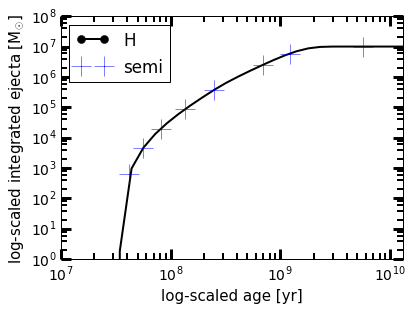

In [45]:
s2.plot_mass(fig=988,specie='H',source='sn1a',label='H',color='k',shape='-',marker='o',markevery=800)
yields1=[]
ages1=[]
m=[1,1.65,2,3,4,5,6,7,12,15,20,25]
ages=[5.67e9,1.211e9,6.972e8,2.471e8,1.347e8,8.123e7,5.642e7,4.217e7,1.892e7,1.381e7,9.895e6,7.902e6]
for m1 in m:
    t=ages[m.index(m1)]
    yields= a* dblquad(f_wd_dtd,0,t,lambda x: spline1(x), lambda x: 8)[0] *1e11*0.1 #special factor
    yields1.append(yields)
    ages1.append(t)
plt.plot(ages1,yields1,marker='+',linestyle='',markersize=20,label='semi')
plt.legend(loc=2)

Simulation results compared with semi-analytical calculations for the SN1 sources with Wiersma (Gauss) implementation.

#### Compare number of WD's in range

In [46]:
print (sum(s2.wd_sn1a_range1)/sum(s2.wd_sn1a_range))

1.0


############################################################################################

### SNIa implementation: Maoz12 $t^{-1}$

In [47]:
s2=s.sygma(iolevel=0,mgal=1e11,dt=1e8,tend=1.3e10,sn1a_rate='maoz',imf_type='salpeter',
           imf_bdys=[1,30],special_timesteps=-1,hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',
           sn1a_on=True, sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')

SYGMA run in progress..
   SYGMA run completed - Run time: 1.17s


In [48]:
Yield_tot_sim=s2.history.ism_iso_yield_1a[-1][0]
from scipy.interpolate import UnivariateSpline
zm_lifetime_grid=s2.zm_lifetime_grid_current
idx_z = (np.abs(zm_lifetime_grid[0]-0.0001)).argmin() #Z=0
grid_masses=zm_lifetime_grid[1][::-1]
grid_lifetimes=zm_lifetime_grid[2][idx_z][::-1]
spline_degree1=2
smoothing1=0
boundary=[None,None]
spline_lifetime = UnivariateSpline(grid_lifetimes,np.log10(grid_masses),bbox=boundary,k=spline_degree1,s=smoothing1)

from scipy.integrate import quad

In [49]:
def spline1(t):
                minm_prog1a=3
                #if minimum progenitor mass is larger than 3Msun due to IMF range:
                return max(minm_prog1a,10**spline_lifetime(np.log10(t)))

            #funciton giving the total (accummulatitive) number of WDs at each timestep
def wd_number(m,t):
                #print ('time ',t)
                #print ('mass ',m)
                mlim=10**spline_lifetime(np.log10(t))
                maxm_prog1a=8

                if mlim>maxm_prog1a:
                        return 0
                else:
                        mmin=0
                        mmax=0
                        inte=0
                        #normalized to 1msun!
                        def g2(mm):
                            return mm*mm**-2.35
                        norm=1./quad(g2,1,30)[0]
                        return  norm*m**-2.35 #self.__imf(mmin,mmax,inte,m)

def maoz_sn_rate(m,t):
                        return  wd_number(m,t)* 4.0e-13 * (t/1.0e9)**-1

def maoz_sn_rate_int(t):
                return quad( maoz_sn_rate,spline1(t),8,args=t)[0]

#in this formula, (paper) sum_sn1a_progenitors number of 
maxm_prog1a=8
longtimefornormalization=1.3e10 #yrs
fIa=0.00147
fIa=1e-3
#A = (fIa*s2.number_stars_born[1]) / quad(maoz_sn_rate_int,0,longtimefornormalization)[0]
A = 1e-3 / quad(maoz_sn_rate_int,0,longtimefornormalization)[0]

print ('Norm. constant A:',A)
n1a= A* quad(maoz_sn_rate_int,0,1.3e10)[0]
Yield_tot=n1a*1e11*0.1 #specialfactor

Norm. constant A: 8.41854414370441


In [50]:
print (Yield_tot_sim)
print (Yield_tot)
print ('Should be 1: ', Yield_tot_sim/Yield_tot)

10000000.0
10000000.0
Should be 1:  1.0


#### Check trend:

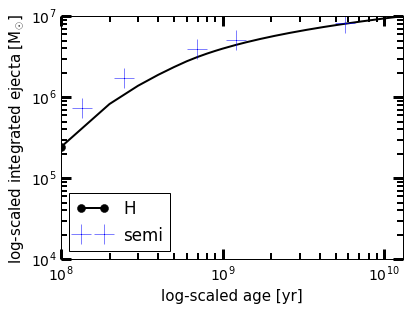

In [51]:
s2.plot_mass(fig=44,specie='H',source='sn1a',label='H',color='k',shape='-',marker='o',markevery=800)
yields1=[]
ages1=[]
m=[1,1.65,2,3,4,5,6,7,12,15,20,25]
ages=[5.67e9,1.211e9,6.972e8,2.471e8,1.347e8,8.123e7,5.642e7,4.217e7,1.892e7,1.381e7,9.895e6,7.902e6]
for m1 in m:
    t=ages[m.index(m1)]
    #yields= a* dblquad(wdfrac,0,t,lambda x: spline1(x), lambda x: 8)[0] *1e11*0.1 
    yields= A*quad(maoz_sn_rate_int,0,t)[0] *1e11*0.1 #special factor
    yields1.append(yields)
    ages1.append(t)
plt.plot(ages1,yields1,marker='+',linestyle='',markersize=20,label='semi')
plt.legend(loc=2)
plt.legend(loc=3)

### Test of parameter tend, dt and special_timesteps

#### First constant timestep size of 1e7

In [52]:
s1=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,special_timesteps=-1,imf_type='salpeter',
           imf_bdys=[1,30],hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, 
           sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn',
          stellar_param_on=False)

SYGMA run in progress..
   SYGMA run completed - Run time: 11.02s


In [53]:
print ('Should be 0: ',s1.history.age[0])
print ('Should be 1: ',s1.history.age[-1]/1.3e10)
print ('Should be 1: ',s1.history.timesteps[0]/1e7)
print ('Should be 1: ',s1.history.timesteps[-1]/1e7)
print ('Should be 1: ',sum(s1.history.timesteps)/1.3e10)

Should be 0:  0
Should be 1:  1.0
Should be 1:  1.0
Should be 1:  1.0
Should be 1:  1.0


#### First timestep size of 1e7, then  in log space to tend with a total number of steps of 200; Note: changed tend

In [54]:
s2=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.5e9,special_timesteps=200,imf_type='salpeter',
           imf_bdys=[1,30],hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, 
           sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')

SYGMA run in progress..
   SYGMA run completed - Run time: 1.85s


In [55]:
print ('Should be 0: ',s2.history.age[0])
print ('Should be 1: ',s2.history.age[-1]/1.5e9)
print ('Should be 201: ',len(s2.history.age))
print ('Should be 1: ',s2.history.timesteps[0]/1e7)
#print ('in dt steps: ',s2.history.timesteps[1]/1e7,s1.history.timesteps[2]/1e7,'..; larger than 1e7 at step 91!')
print ('Should be 200: ',len(s2.history.timesteps))
print ('Should be 1: ',sum(s2.history.timesteps)/1.5e9)

Should be 0:  0
Should be 1:  1.0
Should be 201:  201
Should be 1:  1.0
Should be 200:  200
Should be 1:  1.0


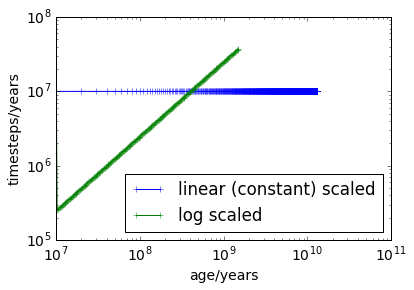

In [56]:
plt.figure(55)
plt.plot(s1.history.age[1:],s1.history.timesteps,label='linear (constant) scaled',marker='+')
plt.plot(s2.history.age[1:],s2.history.timesteps,label='log scaled',marker='+')
plt.yscale('log');plt.xscale('log')
plt.xlabel('age/years');plt.ylabel('timesteps/years');plt.legend(loc=4)

#### Choice of dt should not change final composition:

for special_timesteps:

In [57]:
s3=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,special_timesteps=-1,imf_type='salpeter',imf_bdys=[1,30],
           hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', 
           iniabu_table='yield_tables/iniabu/iniab_h1.ppn',stellar_param_on=False)
s4=s.sygma(iolevel=0,mgal=1e11,dt=1.3e10,tend=1.3e10,special_timesteps=-1,imf_type='salpeter',imf_bdys=[1,30],
           hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt',
           iniabu_table='yield_tables/iniabu/iniab_h1.ppn',stellar_param_on=False)
s5=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,special_timesteps=200,imf_type='salpeter',imf_bdys=[1,30],
           hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt',
           iniabu_table='yield_tables/iniabu/iniab_h1.ppn',stellar_param_on=False)
s6=s.sygma(iolevel=0,mgal=1e11,dt=1.3e10,tend=1.3e10,special_timesteps=200,imf_type='salpeter',imf_bdys=[1,30],
           hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', 
           iniabu_table='yield_tables/iniabu/iniab_h1.ppn',stellar_param_on=False)

SYGMA run in progress..
   SYGMA run completed - Run time: 11.15s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.01s
SYGMA run in progress..
   SYGMA run completed - Run time: 1.79s
SYGMA run in progress..
   SYGMA run completed - Run time: 1.64s


In [58]:
#print (s3.history.ism_iso_yield[-1][0] == s4.history.ism_iso_yield[-1][0] why false?)
print ('should be 1 ',s3.history.ism_iso_yield[-1][0]/s4.history.ism_iso_yield[-1][0])
#print (s3.history.ism_iso_yield[-1][0],s4.history.ism_iso_yield[-1][0])
print ('should be 1',s5.history.ism_iso_yield[-1][0]/s6.history.ism_iso_yield[-1][0])
#print (s5.history.ism_iso_yield[-1][0],s6.history.ism_iso_yield[-1][0])

should be 1  1.0
should be 1 1.0


### Test of parameter mgal - the total mass of the SSP

Test the total isotopic and elemental ISM matter at first and last timestep.

In [59]:
s1=s.sygma(iolevel=0,mgal=1e7,dt=1e7,tend=1.3e10,hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',
           sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
s2=s.sygma(iolevel=0,mgal=1e8,dt=1e8,tend=1.3e10,hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',
           sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
s3=s.sygma(iolevel=0,mgal=1e9,dt=1e9,tend=1.3e10,hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',
           sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')

SYGMA run in progress..
   SYGMA run completed - Run time: 0.28s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.28s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.28s


In [60]:
print ('At timestep 0: ',sum(s1.history.ism_elem_yield[0])/1e7,sum(s2.history.ism_elem_yield[0])/1e8,sum(s3.history.ism_elem_yield[0])/1e9)
print ('At timestep 0: ',sum(s1.history.ism_iso_yield[0])/1e7,sum(s2.history.ism_iso_yield[0])/1e8,sum(s3.history.ism_iso_yield[0])/1e9)

At timestep 0:  1.0 1.0 1.0
At timestep 0:  1.0 1.0 1.0


In [61]:
print ('At last timestep, should be the same fraction: ',sum(s1.history.ism_elem_yield[-1])/1e7,sum(s2.history.ism_elem_yield[-1])/1e8,sum(s3.history.ism_elem_yield[-1])/1e9)
print ('At last timestep, should be the same fraction: ',sum(s1.history.ism_iso_yield[-1])/1e7,sum(s2.history.ism_iso_yield[-1])/1e8,sum(s3.history.ism_iso_yield[-1])/1e9)

At last timestep, should be the same fraction:  0.0170583657213 0.0170583657213 0.0170583657213
At last timestep, should be the same fraction:  0.0170583657213 0.0170583657213 0.0170583657213


### Test of SN rate: depend on timestep size: shows always mean value of timestep; larger timestep> different mean

In [62]:
s1=s.sygma(iolevel=0,mgal=1e11,dt=7e6,tend=1e8,imf_type='salpeter',imf_bdys=[1,30],hardsetZ=0.0001,
           table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=True, sn1a_table='yield_tables/sn1a_h1.txt',
           iniabu_table='yield_tables/iniabu/iniab_h1.ppn',pop3_table='yield_tables/popIII_h1.txt')
s2=s.sygma(iolevel=0,mgal=1e11,dt=7e6,tend=1e8,special_timesteps=-1,imf_type='salpeter',imf_bdys=[1,30],
           hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=True, 
           sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn',
           pop3_table='yield_tables/popIII_h1.txt')
s3=s.sygma(iolevel=0,mgal=1e11,dt=1e6,tend=1e8,special_timesteps=-1,imf_type='salpeter',imf_bdys=[1,30],
           hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=True, sn1a_table='yield_tables/sn1a_h1.txt', 
           iniabu_table='yield_tables/iniabu/iniab_h1.ppn',pop3_table='yield_tables/popIII_h1.txt')
s4=s.sygma(iolevel=0,mgal=1e11,dt=3e7,tend=1e8,special_timesteps=-1,imf_type='salpeter',imf_bdys=[1,30],hardsetZ=0.0001,
           table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=True, sn1a_table='yield_tables/sn1a_h1.txt', 
           iniabu_table='yield_tables/iniabu/iniab_h1.ppn',pop3_table='yield_tables/popIII_h1.txt')

SYGMA run in progress..
   SYGMA run completed - Run time: 0.29s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.15s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.95s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s


(100.0, 10000.0)

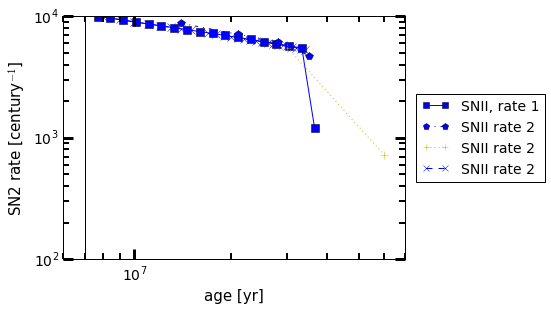

In [63]:
s1.plot_sn_distr(rate=True,rate_only='sn2',label1='SN1a, rate, 1',label2='SNII, rate 1',marker1='o',marker2='s',shape2='-',markevery=1)
s2.plot_sn_distr(rate=True,rate_only='sn2',label1='SN1a, rate, 2',label2='SNII rate 2',marker1='d',marker2='p',markevery=1,shape2='-.')
s4.plot_sn_distr(rate=True,rate_only='sn2',label1='SN1a, rate, 2',label2='SNII rate 2',marker1='d',marker2='+',markevery=1,shape2=':',color2='y')
s3.plot_sn_distr(rate=True,rate_only='sn2',label1='SN1a, rate, 2',label2='SNII rate 2',marker1='d',marker2='x',markevery=1,shape2='--')
plt.xlim(6e6,7e7)
plt.vlines(7e6,1e2,1e9)
plt.ylim(1e2,1e4)

In [64]:
print (s1.history.sn2_numbers[1]/s1.history.timesteps[0])
print (s2.history.sn2_numbers[1]/s2.history.timesteps[0])
#print (s1.history.timesteps[:5])
#print (s2.history.timesteps[:5])

0.0
0.0


In [65]:
s3=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,imf_type='salpeter',imf_bdys=[1,30],hardsetZ=0.0001,
           table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=True, sn1a_table='yield_tables/sn1a_h1.txt', 
           iniabu_table='yield_tables/iniabu/iniab_h1.ppn',pop3_table='yield_tables/popIII_h1.txt',
          stellar_param_on=False)
s4=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,special_timesteps=-1,imf_type='salpeter',imf_bdys=[1,30],
           hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=True, 
           sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn',
           pop3_table='yield_tables/popIII_h1.txt',stellar_param_on=False)

SYGMA run in progress..
   SYGMA run completed - Run time: 0.28s
SYGMA run in progress..
   SYGMA run completed - Run time: 11.11s


##### Rate does not depend on timestep type:

(30000000.0, 10000000000.0)

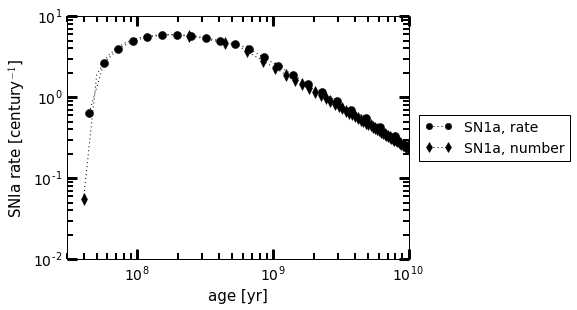

In [66]:
s3.plot_sn_distr(fig=66,rate=True,rate_only='sn1a',label1='SN1a, rate',label2='SNII, rate',marker1='o',marker2='s',markevery=1)
s4.plot_sn_distr(fig=66,rate=True,rate_only='sn1a',label1='SN1a, number',label2='SNII number',marker1='d',marker2='p')
plt.xlim(3e7,1e10)

(1000000.0, 15000000000.0)

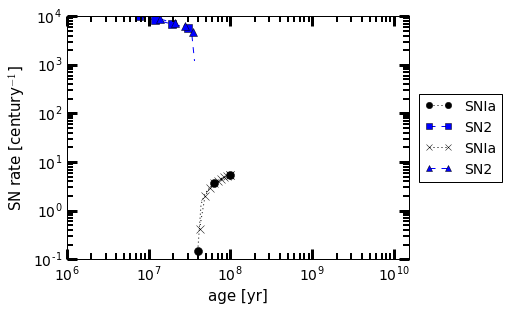

In [67]:
s1.plot_sn_distr(fig=77,rate=True,marker1='o',marker2='s',markevery=5)
s2.plot_sn_distr(fig=77,rate=True,marker1='x',marker2='^',markevery=1)
#s1.plot_sn_distr(rate=False)
#s2.plot_sn_distr(rate=True)
#s2.plot_sn_distr(rate=False)
plt.xlim(1e6,1.5e10)
#plt.ylim(1e2,1e4)

### Test of parameter transitionmass : Transition from AGB to massive stars

Check  if transitionmass is properly set

In [68]:
s1=s.sygma(iolevel=0,imf_bdys=[1.65,30],transitionmass=8,mgal=1e11,dt=1e7,tend=1.3e10,imf_type='salpeter',
           hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, 
           sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
s2=s.sygma(iolevel=0,imf_bdys=[1.65,30],transitionmass=10,mgal=1e11,dt=1e7,tend=1.3e10,imf_type='salpeter',
           hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, 
           sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
Yield_tot_sim_8=s1.history.ism_iso_yield_agb[-1][0]
Yield_tot_sim_10=s2.history.ism_iso_yield_agb[-1][0]

SYGMA run in progress..
   SYGMA run completed - Run time: 0.28s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.29s


In [69]:
alphaimf=2.35
k_N=1e11*(alphaimf-2)/ (-1.65**-(alphaimf-2) + 30**-(alphaimf-2))

N_tot=k_N/(alphaimf-1) * (-1.65**-(alphaimf-1) + 8**-(alphaimf-1))
Yield_tot_8=0.1*N_tot

N_tot=k_N/(alphaimf-1) * (-1.65**-(alphaimf-1) + 10**-(alphaimf-1))
Yield_tot_10=0.1*N_tot
#N_tot=k_N/(alphaimf-1) * (-1.65**-(alphaimf-1) + 5**-(alphaimf-1))
#Yield_tot_5=0.1*N_tot

In [70]:
print ('1:',Yield_tot_sim_8/Yield_tot_8)
print ('1:',Yield_tot_sim_10/Yield_tot_10)
#print ('1:',Yield_tot_sim_5/Yield_tot_5)

1: 1.0
1: 1.0


# imf_yield_range - include yields only in this mass range

In [72]:
s0=s.sygma(iolevel=0,iniZ=0.0001,imf_bdys=[0.01,100],imf_yields_range=[1,100],
           hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, 
           sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')

SYGMA run in progress..
   SYGMA run completed - Run time: 0.28s
